# Observing "impossible" double descent in simple linear regression

Double descent is the empirical observation that test error (also called prediction error or out of sample error) rises with more parameter added to the model but sometimes can can also "descend" again as more parameters are added.  Traditional bias-variance theory led many to believe this should be impossible.  There was a U-curved "sweet spot" of optimal test error with only a few parameters.  Simple math shows that sampling variance increases as more parameters are added (in the absence of regularization).

More specifically, the U curve has various regions:
 * With fewer parameters than the "sweet spot," the model **underfits** the data; training error and test error are both high. 
 * With more parameters than the sweet spot, the model **overfits** the data, meaning the parameters are fitting noise rather than signal; as a result training error is low but test error is high.
So... how could adding even more parameters avoid the curve of overfitting?

At first, the empirical observation of double descent was assumed to be due to  special features of deep learning or neural nets.  But in the 2020's, double descent was observed in linear regression, too.  It was a shock.  Various researchers then started developing the theory on how, when, and where linear regression can exhibit double descent, including the Dar et al. (2023) paper cited below.  The Dar paper greatly inspired me.

But the math is complicated.  Code is simpler.  So this notebook illustrates the bias-variance trade-off and double descent in a linear regression model using simple python libraries.  These also help us test our intuitions by running different variations.  I also address an objection by Curth et al. (2023).

# Libraries

In [113]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
# from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

# Data set

Here I load a data set to analyze.  In an earlier [R version of this notebook](https://github.com/jeanimal/farewell_bias_variance), I used the "mtcars" data set which has data on various models in Motor Trend cars of the year.

The goal is to predict the miles per gallon (mpg) of various models based on their other characteristics.

In [114]:
import os
notebook_path = os.path.abspath("double_descent_mtcars_reg.ipynb")
print(notebook_path)
csv_path = os.path.join(os.path.dirname(notebook_path), "data/mt_cars.csv")
print(csv_path)

/Users/jeanortega/PycharmProjects/pythonProject1/double_descent_mtcars_reg.ipynb
/Users/jeanortega/PycharmProjects/pythonProject1/data/mt_cars.csv


In [115]:
df = pd.read_csv(csv_path)

In [116]:
df.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


# Split X and y

Here we put the data in a standard format for sklearn's model estimtion and error metrics.  If you use your own data set, you will need to tweak the target column and remove the non-numeric columns-- or code them into numbers, e.g. with one-hot encoding.

In [117]:
TARGET_COL = "mpg"

In [118]:
NON_NUMERIC_COLS = ["model"]

In [119]:
y = df[TARGET_COL]
X = df.drop([TARGET_COL] + NON_NUMERIC_COLS,axis=1)

# Making the study of overparameterization easier

In this section, I summarize functions to sample our data by the number of rows and columns.

Why?

To study bias-variance and double descent, we need to view our model estimation in terms of the overparameterization ratio, defined as:

      `overparametrization ratio = num_parameters / num_rows`

 The overparametrization ratio distinguish these classes of behavior:
    * less than 1: uncerparameterized (where we will see bias-variance U curves)
    * equal to 1: interpolating
    * greater than 1: overparameterized (where we might see the right half of double descent).

In many estimation models, the number of parameters is closely related to the number of columns. For example, in ordinary least squares (OLS) regression without an intercept, the number of parameters equals the number of columns, and when there is an intercept, the number of parameters is number of columns + 1.

However, sklearn's train_test_split function takes a proportion of taining rows as input and always uses all columns of the data set.  So I wrote wrappers to directly control the number of training rows and columns.

The overparameterization ratio is described in this paper:
    Hastie, T., Montanari, A., Rosset, S., & Tibshirani, R. J. (2020). Surprises in High-Dimensional
    Ridgeless Least Squares Interpolation. http://arxiv.org/abs/1903.08560


Below I do manual sampling of rows and columns to give an idea of the goal.

In [120]:
rng = np.random.RandomState(10) # For reproducibility
num_sampled_rows = 4
num_sampled_columns = 5

In [121]:
row_indices = rng.choice(df.index, num_sampled_rows, replace=False)

In [122]:
X_subset = X.iloc[row_indices]
y_subset = y.iloc[row_indices]

In [123]:
X_subset = X_subset.sample(n=num_sampled_columns, random_state=rng, axis=1)

In [124]:
X_subset

,hp,cyl,carb,qsec,wt
20,97,4,1,20.01,2.465
7,62,4,2,20.00,3.190
5,105,6,1,20.22,3.460
2,93,4,1,18.61,2.320


In [125]:
y_subset

20    21.5
7     24.4
5     18.1
2     22.8
Name: mpg, dtype: float64

## Using the package just to sample rows and columns

I have a python package to help sample a dataframe in a way that makes it easy to control the rows and columns, which helps us control the overparameterization ratio, defined as the number of parameters / number of rows.

In [126]:
from double_descent_dar import sample_eval

In [127]:
random_state = np.random.RandomState(15) # For reproducibility
num_sampled_rows = 3
num_sampled_columns = 4

In [128]:
X_train, X_test, y_train, y_test = sample_eval.train_test_split_by_rows_and_cols(X, y, num_train_rows=num_sampled_rows, num_columns=num_sampled_columns, replace=False, random_state=random_state, verbose=True)

using train_size 0.09375


In [129]:
X_train

,hp,vs,disp,drat
17,66,1,78.7,4.08
29,175,0,145.0,3.62
15,215,0,460.0,3.00


In [130]:
y_train

17    32.4
29    19.7
15    10.4
Name: mpg, dtype: float64

What we will do is fit a linear regression on this data and then measure out of sample error.


## Key configs you can try changing

Set the model to fit and the error metric from sklearn.

In [131]:
model = linear_model.LinearRegression(fit_intercept=True)

In [132]:
metric = mean_absolute_error
# metric = root_mean_squared_error

## Running the simplest experiment

In [133]:
model.fit(X_train, y_train)

LinearRegression()

In [134]:
train_error = metric(y_train, model.predict(X_train))
train_error

np.float64(8.881784197001252e-15)

In [135]:
test_error = metric(y_test, model.predict(X_test))
test_error

np.float64(4.843245291583992)

As expected, train error (in-sample fit) is lower than test error (out of sample).

We will do this again and again and look at the mean metric value for combinations of number of rows and columns.

# Bias-variance U curve

Seeing a traditional bias-variance U curve requires that the number of parameters should be a lot less than the number of rows.  Since the data set has 9 columns, we will need a lot more rows. This section will sample 15 rows (out of a total of 32) to train on.

We will sample between 2 and 8 columns (out of a total of 10 numeric columns) to see how the error metric varies by the number of parameters.

Note that the regression used here includes an intercept, so 8 columns + 1 intercept -> 9 parameters.  With 15 rows to train on, full interpolation would be reached with 15 columns.

In [136]:
X.shape

(32, 10)

In [137]:
num_train_rows = 15

In [138]:
model = linear_model.LinearRegression(fit_intercept=True)

We will look at the train and test error with the root mean squared metric, the metric minimized by Ordinary Least Squares (OLS)-- although OLS minimizes only training (in-sample) error. 

In [139]:
print('Using ', metric.__name__)

Using  mean_absolute_error


In [140]:
metrics = [
        sample_eval.MetricTuple('train', metric_func=metric, dataset_type=sample_eval.DatasetType.train),
        sample_eval.MetricTuple('test', metric_func=metric, dataset_type=sample_eval.DatasetType.test)
    ]

In [141]:
metrics[0].metric_func.__name__

'mean_absolute_error'

In [142]:
num_samples = 300
random_state = np.random.RandomState(11)  # set for reproducibility
num_columns_list = range(1, X.shape[1])
metric_dict = sample_eval.sample_and_calc_metrics_by_rows_and_cols(
    X, y, num_train_rows, num_columns_list=num_columns_list, model=model,
    metric_tuples=metrics, num_samples=num_samples,
    replace=False, random_state=random_state)

Below we see the mean training error decreases for more columns sampled.  Starting at 6 columns sampled, mean root mean square error drops below 2.0.

In contrast, mean test error goes down but then goes back up.   Mean test error reaches its minimum at 3 columns sampled, at a value of ~3.45. 

In [143]:
print(pd.DataFrame({
    'cols':num_columns_list,
    'train': np.mean(metric_dict['train'], axis=0),
    'test': np.mean(metric_dict['test'], axis=0)}).to_string(index=False))

 cols    train     test
    1 3.140950 3.643313
    2 2.481248 3.147313
    3 2.088390 2.790569
    4 1.838206 2.830544
    5 1.674939 2.933997
    6 1.556699 3.071974
    7 1.416896 3.367801
    8 1.283480 3.788025
    9 1.182796 4.231364


Let's plot test error to see the classic U shape.

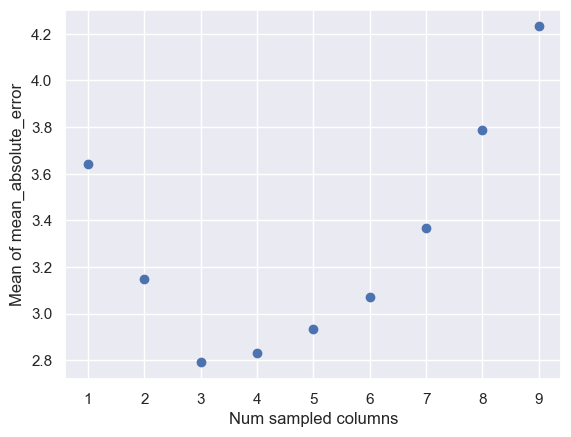

In [144]:
plt.scatter(num_columns_list, np.mean(metric_dict['test'], axis=0), label='test')
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + metrics[0].metric_func.__name__)
# plt.legend()
plt.show()

The test error (in orange) display a beautiful U shape.  The linear regression's lowest average test (out-of-sample) error was achieved at 3 columns, which with the intercept means 4 parameters to fit.  This is much less than the 9 columns available in the data set.

(There is no simple theory that predicts what the optimal number of parameters will be.) 


Now let's look at a plot that includes the training error.  Notice that the training error continues to decrease as more columns are added.

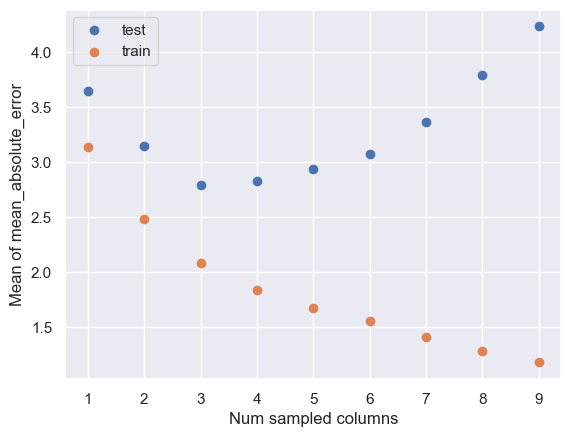

In [145]:
plt.scatter(num_columns_list, np.mean(metric_dict['test'], axis=0), label='test')
plt.scatter(num_columns_list, np.mean(metric_dict['train'], axis=0), label='train')
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + metrics[0].metric_func.__name__)
plt.legend()
plt.show()

## Double descent

A paper by Dar et al. (), called "Farewell to Bias Variance?" showed mathematically that double descent could be exhibited by linear regression under certain conditions. 

The paper: 
Yehuda Dar, Muthukumar, V., & Baraniuk, R. (2021). A Farewell to the Bias-Variance Tradeoff? An Overview of the Theory of Overparameterized Machine Learning. https://arxiv.org/abs/2109.02355


Here I show double descent empirically on the mtcars data set (widely used by R users).

Seeing double descent requires that the number of parameters should be a lot MORE than the number of rows. Since the data set has only 9 columns, we achieve this with a trick-- sampling fewer rows.

This section will train on 7 rows (out of a total of 32).

As before, will sample between 2 and 8 columns (out of a total of 9 columns) to see how the error metric varies by the number of parameters.  

The linear regression model will be able to fully interpolate the data at 7 columns because it is fit to 7 rows.

In [146]:
num_train_rows = 7
model = linear_model.LinearRegression(fit_intercept=True)

We will look at the train and test error of root mean squared error.

In [147]:
metric = mean_absolute_error
metrics = [
        sample_eval.MetricTuple('train', metric_func=metric, dataset_type=sample_eval.DatasetType.train),
        sample_eval.MetricTuple('test', metric_func=metric, dataset_type=sample_eval.DatasetType.test)
    ]

In [148]:
num_samples = 300
num_columns_list = range(1, X.shape[1])
random_state = np.random.RandomState(33) # set for reproducibility
metric_dict = sample_eval.sample_and_calc_metrics_by_rows_and_cols(X, y, num_train_rows, num_columns_list=num_columns_list, model=model, metric_tuples=metrics, num_samples=num_samples, replace=False, random_state=random_state)

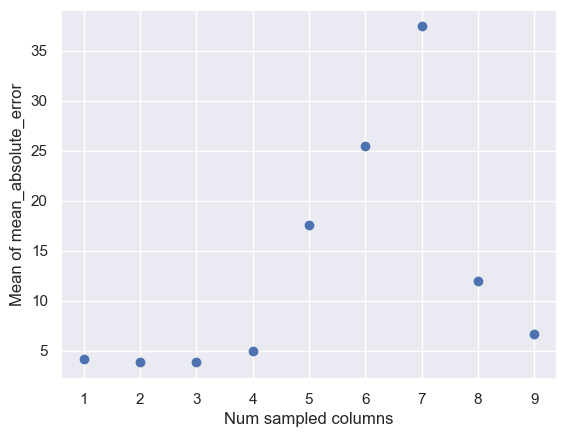

In [149]:
plt.scatter(num_columns_list, np.mean(metric_dict['test'], axis=0), label='test')
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + metrics[0].metric_func.__name__)
# plt.legend()
plt.show()

As predicted, there was a spike in test (out of sample) error followed by a descent in error after the spike.  That is double descent in a linear regression.  The maximum was reached at 7 sampled columns.

Double descent was formerly thought to be a weird feature of fitting neural nets, but here we observe it with simple, traditional linear regression.

## Deeper dive into interpolation

The double descent spike should happen at the interpolation threshold.  Interpolation means the data could be fit perfectly, so the training error is zero.  Let's look at the mean training error for each number of sampled columns

In [150]:
print(pd.DataFrame({'columns':num_columns_list, 'mean train error':np.mean(metric_dict['train'], axis=0), 'mean test error':np.mean(metric_dict['test'], axis=0)}).to_string(index=False))

 columns  mean train error  mean test error
       1      2.916047e+00         4.148211
       2      2.070648e+00         3.814284
       3      1.527387e+00         3.873608
       4      1.092764e+00         4.918830
       5      6.460086e-01        17.518878
       6      1.178664e-01        25.472517
       7      2.389706e-02        37.414643
       8      3.522327e-03        11.995624
       9      8.089698e-14         6.634006


I predicted that interpolation would happen at 7 sampled columns because we selected 7 rows, but we see the mean training error is not 0 at 7 columns nor even at 8 columns!

Considering why, focus on the mtcars data set (documentation: https://www.rdocumentation.org/packages/datasets/versions/3.6.2/topics/mtcars).  It has some very low-variance, uninformative columns.  The column `vs` (engine type v or s) and the column `am` (automatic transmission or not) are both binary.  So if these columns were selected, perfect interpolation would not be achievable even with 7 columns for 7 rows. 

For completeness, below is a plot that includes both training and test error.

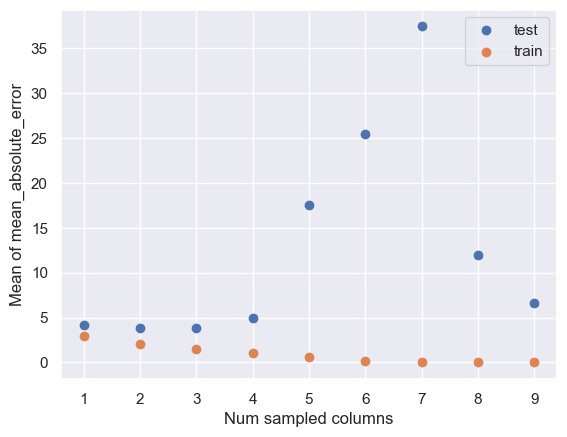

In [151]:
plt.scatter(num_columns_list, np.mean(metric_dict['test'], axis=0), label='test')
plt.scatter(num_columns_list, np.mean(metric_dict['train'], axis=0), label='train')
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + metrics[0].metric_func.__name__)
plt.legend()
plt.show()

# MOAR parameters-- deeper double descent

So far, we have been limited in checking out the right side of the double descent curve because our data set has only 9 columns.  But the conditions in the paper by Dar et al mentioned the degree of signal and noise in the data, saying double descent predominates when noise is high relative to signal.  That gave me an idea to extend the data set by adding noisy columns.  Not only will that give us more "room" for the right side of the plot but also it fits the conditions of the theorem to give a high chance of double descent.

So let's add 20 noisy columns!

In [152]:
rng = np.random.default_rng(2) # For reproducibility
num_random_columns = 20
rand_array = rng.standard_normal(size=(X.shape[0], num_random_columns))
rand_df = pd.DataFrame(rand_array, columns=[f'rand_{i}' for i in range(num_random_columns)])

In [153]:
X_plus_rand = pd.concat([X, rand_df], axis=1)
X_plus_rand.head()

,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,...,rand_10,rand_11,rand_12,rand_13,rand_14,rand_15,rand_16,rand_17,rand_18,rand_19
0,6,160.0,110,3.90,2.620,16.46,0,1,4,4,...,0.977567,-0.310557,-0.328824,-0.792147,0.454958,-0.099198,0.545289,-0.607186,0.126828,-0.892274
1,6,160.0,110,3.90,2.875,17.02,0,1,4,4,...,0.841459,0.128716,1.078342,0.722431,0.210572,0.284038,-0.169760,0.868460,-1.129716,-0.421859
2,4,108.0,93,3.85,2.320,18.61,1,1,4,1,...,1.034866,-1.418666,0.153582,1.215758,0.087919,0.999701,2.374887,0.273932,-0.280382,-0.771052
3,6,258.0,110,3.08,3.215,19.44,1,0,3,1,...,1.510119,-0.008956,-0.742155,0.477929,-0.076588,-1.254187,-0.885067,1.766779,0.354351,0.416387
4,8,360.0,175,3.15,3.440,17.02,0,0,3,2,...,1.428544,-0.667620,0.153412,-0.836387,-0.222235,0.047404,-0.434685,-0.702888,-0.677886,-0.821160


In [154]:
num_samples = 300
num_columns_list_with_rand = range(1, X_plus_rand.shape[1])
random_state = np.random.RandomState(33) # set for reproducibility
metric_dict_with_rand = sample_eval.sample_and_calc_metrics_by_rows_and_cols(X_plus_rand, y, num_train_rows, num_columns_list=num_columns_list_with_rand, model=model, metric_tuples=metrics, num_samples=num_samples, replace=False, random_state=random_state)

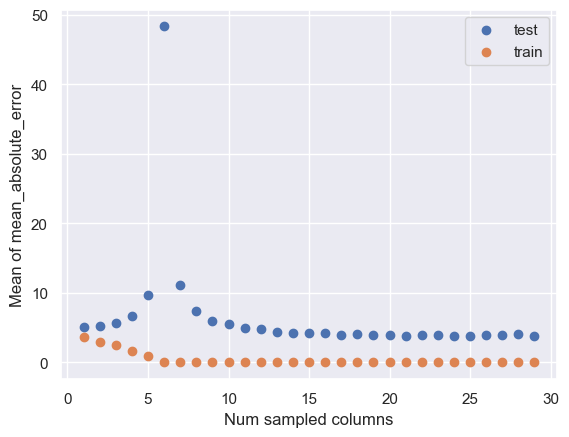

In [155]:
plt.scatter(num_columns_list_with_rand, np.mean(metric_dict_with_rand['test'], axis=0), label='test')
plt.scatter(num_columns_list_with_rand, np.mean(metric_dict_with_rand['train'], axis=0), label='train')
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + metrics[0].metric_func.__name__)
plt.legend()
plt.show()

Wow, that is a beautiful double descent shape!  It looks textbook ready.

But note that I crafted a situation that was well-suited for double descent to demonstrate that it can happen even with simple linear regression.  Applying ordinary least squares regression will not exhibit double descent on *every* data set.  The Dar et al. paper found necessary and sufficient conditions that are required for double descent.  Below is a somewhat intuitive (but inevitably inaccurate) summary of the conditions in section 3.3.3 [2]:

* Low-dimensional signal structure in the data (where signal means de-noised).
* Low effective dimension in the data (a few large eigenvectors). (A tutorial on effective dimension and its distinction from intrinsic dimension: https://pubmed.ncbi.nlm.nih.gov/32223436/.)
* Alignment: The highest-signal data dimensions must be aligned with the highest effective dimensions (largest eigenvectors in the data).
* An abundance of low-signal (but non-zero) features in the model.

Without these conditions, there is a “rich variety of generalization behaviors” in the overparameterized regime of linear regression.

### Comparing fits on data with and without noise

If you compare the y-axis across graphs, you will notice that overall error is higher with the noisy data.  Here I will plot on the same graph to make it easier to see.

The lesson from this observation is that you will achieve lower out-of-sample error if you can get your hands on the noise-free data, where you would want to fit a relatively small model.  However, if you have noisy data, you might want to add as many features as possible in order to try to achieve the benefits of double descent.

I will use seaborn to plot the comparison because otherwise the points overlap too much.

In [156]:
pad_len = len(num_columns_list_with_rand) - len(num_columns_list)
padded_mt_cars = np.concatenate((np.mean(metric_dict['test'], axis=0), np.array([np.nan] * pad_len)))
df_wide = pd.DataFrame(
    {'cols':num_columns_list_with_rand,
     'mt_cars':padded_mt_cars,
     'mt_cars_plus_rand':np.mean(metric_dict_with_rand['test'], axis=0)})
df = pd.melt(df_wide, ['cols'], var_name='data_set', value_name='mean test error')
df.head()

,cols,data_set,mean test error
0,1,mt_cars,4.148211
1,2,mt_cars,3.814284
2,3,mt_cars,3.873608
3,4,mt_cars,4.918830
4,5,mt_cars,17.518878


<Axes: xlabel='cols', ylabel='mean test error'>

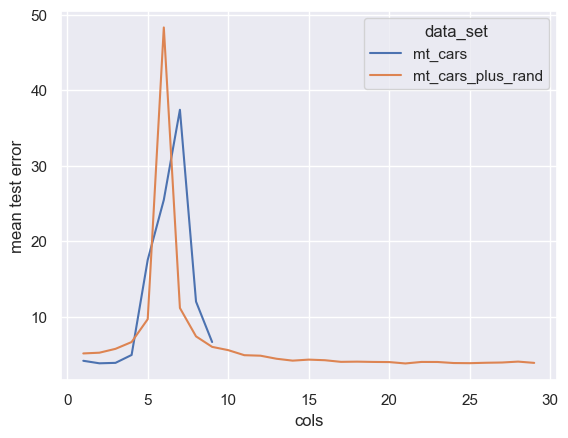

In [157]:
sns.set_theme()
sns.lineplot(data=df, x='cols', y='mean test error', hue='data_set')

Recall this was for 
`num_train_rows = 7`

### Comparison with training on 9 rows

Let's try again with 9 training rows, which reaches interpolation at the full sample of 9 columns.  We predict this will push the interpolation threshold to the right because the interpolation threshold is higher.

In [158]:
num_train_rows = 10

In [159]:
num_samples = 300
num_columns_list = range(1, X.shape[1])
random_state = np.random.RandomState(33) # set for reproducibility
metric_dict = sample_eval.sample_and_calc_metrics_by_rows_and_cols(X, y, num_train_rows, num_columns_list=num_columns_list, model=model, metric_tuples=metrics, num_samples=num_samples, replace=False, random_state=random_state)

In [160]:
num_samples = 300
num_columns_list_with_rand = range(1, X_plus_rand.shape[1])
random_state = np.random.RandomState(33) # set for reproducibility
metric_dict_with_rand = sample_eval.sample_and_calc_metrics_by_rows_and_cols(X_plus_rand, y, num_train_rows, num_columns_list=num_columns_list_with_rand, model=model, metric_tuples=metrics, num_samples=num_samples, replace=False, random_state=random_state)

In [161]:
pad_len = len(num_columns_list_with_rand) - len(num_columns_list)
padded_mt_cars = np.concatenate((np.mean(metric_dict['test'], axis=0), np.array([np.nan] * pad_len)))
df_wide = pd.DataFrame(
    {'cols':num_columns_list_with_rand,
     'mt_cars':padded_mt_cars,
     'mt_cars_plus_rand':np.mean(metric_dict_with_rand['test'], axis=0)})
df = pd.melt(df_wide, ['cols'], var_name='data_type', value_name='mean test error')

<Axes: xlabel='cols', ylabel='mean test error'>

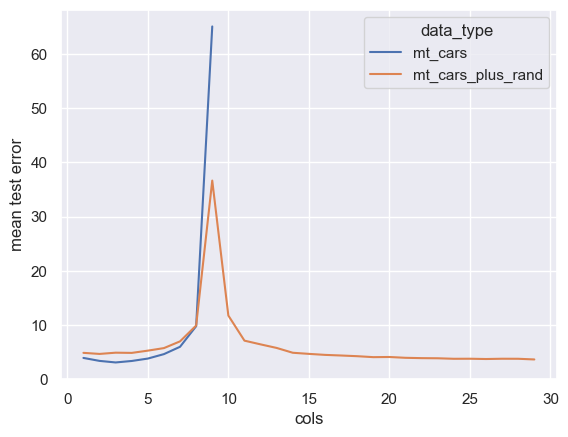

In [162]:
sns.set_theme()
sns.lineplot(data=df, x='cols', y='mean test error', hue='data_type')

For a fixed number of rows, the noise-free data gets a deeper U shape-- and thus lower test error-- below the interpolation threshold.

## Conclusion of comparison

All this theory is nice, but some readers just want to know what to do.

* If you have a data set of well-specified features, go ahead and use them and seek the few features that work well in the traditional underparameterized regime. No need to collect more features, as you are unlikely to benefit. (Even if you observe a second descent in test error, it is unlikely to be less than the minimal underparameterized test error.)
* If you have a data set with a large number of low-signal features-- or, put another way, poorly-specified features-- try using as many as you can.  You are trying to go deep in the overparameterized regime in the hope that double descent will lower your test error.
* Regularization is a wonderful tool 

# Also comparing with regularization

But wait!  In real life we typically use regularization when we have more columns than rows (a.k.a. more features than examples.)  Is regularization better or worse than interpolation?  Dar et al review some studies and conclude:

"These results suggest that optimally tuned regularization will always dominate interpolation. From this perspective, the recent flurry of results show that interpolation is relatively harmless, rather than being relatively beneficial. However, to obtain the full extent of benefit of regularization over interpolation, we need to optimally tune the regularization parameter. This is usually unknown and needs to be estimated from data."

Let's see what happens on our mtcars + random data set.  I will try the default value of the alpha regularizer, in sklearn, which is 1.0.  Recall that ridge regression pulls all the beta weights closer to 0, with weights approaching the limit of 0 as alpha goes to infinity.  alpha=0 is no regularization, equivalent to ordinary least squares regression.

In [163]:
model = linear_model.Ridge(alpha=1.0)
num_samples = 300
num_columns_list_with_rand = range(1, X_plus_rand.shape[1])
random_state = np.random.RandomState(55) # set for reproducibility
metric_dict_with_rand_ridge_1 = sample_eval.sample_and_calc_metrics_by_rows_and_cols(X_plus_rand, y, num_train_rows, num_columns_list=num_columns_list_with_rand, model=model, metric_tuples=metrics, num_samples=num_samples, replace=False, random_state=random_state)

In [164]:
pad_len = len(num_columns_list_with_rand) - len(num_columns_list)
padded_mt_cars = np.concatenate((np.mean(metric_dict['test'], axis=0), np.array([np.nan] * pad_len)))
df_wide = pd.DataFrame(
    {'cols':num_columns_list_with_rand,
     'mt_cars':padded_mt_cars,
     'mt_cars_plus_rand':np.mean(metric_dict_with_rand['test'], axis=0),
     'mt_cars_plus_rand_ridge_1':np.mean(metric_dict_with_rand_ridge_1['test'], axis=0)
     })
df = pd.melt(df_wide, ['cols'], var_name='data_n_model', value_name='mean test error')

<Axes: xlabel='cols', ylabel='mean test error'>

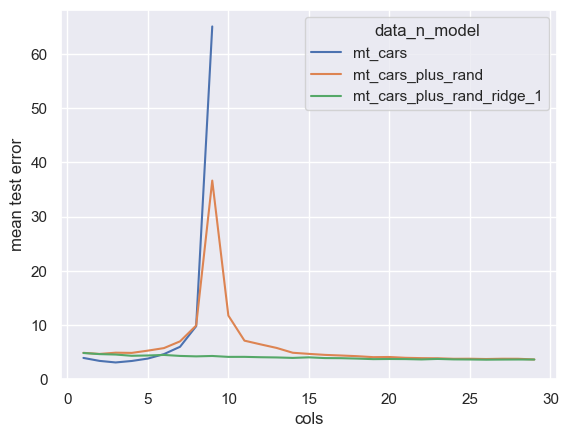

In [165]:
sns.set_theme()
sns.lineplot(data=df, x='cols', y='mean test error', hue='data_n_model')

Wow!  Ridge regression just totally ignores the interpolation boundary and consistently performs well.

That said, it cannot perform well as the noise-free data in mt_cars when the regression is tuned for a "sweet spot" of number of variables.  But if the data set is full of noisy extra columns, then ridge regression is the winner.

Does ridge regression beat interpolation for every number of columns? 

Recall the meaning of the labels:
* mt_cars_plus_rand was fitted with standard OLS, meaning it interpolates for cols >= rows.
* mt_cars_plus_rand_ridge_1 was fitted with ridge(alpha=1) 

The lines overlap in seaborn, so let's zoom in on the values.

In [166]:
pivoted_df = df.pivot(index='data_n_model', columns='cols', values='mean test error')

Below are the first 8 columns, leading up the interpolation regime.

In [167]:
pivoted_df.iloc[:,0:8]

cols,1,2,3,4,5,6,7,8
data_n_model,,,,,,,,
mt_cars,3.924943,3.376051,3.089337,3.361050,3.806478,4.626480,5.980275,9.779823
mt_cars_plus_rand,4.861888,4.662386,4.891360,4.851572,5.268675,5.738303,6.981471,9.898500
mt_cars_plus_rand_ridge_1,4.834739,4.628769,4.549736,4.318888,4.372893,4.475069,4.293218,4.211633


Ridge regression and interpolation are essentially equivalent for 1-2 columns, but interpolation starts doing worse already at 3-4 columns.  (The non-noisy data does well until 6-7 columns,) 

Now let's look in the double descent regime, with a lot of columns.

In [168]:
pivoted_df.iloc[:,25:30]

cols,26,27,28,29
data_n_model,,,,
mt_cars,NaN,NaN,NaN,NaN
mt_cars_plus_rand,3.722597,3.773991,3.766764,3.643582
mt_cars_plus_rand_ridge_1,3.600720,3.622580,3.634746,3.625824


So if you have random noise injected in your mtcars data set, then ridge regression with alpha=1 dominates interpolation  It has a minor advantage for few columns and 20+ columns, but it has a huge advantage around the interpolation regime, where it does not spike in test error at all.

## Regularization comparison summary

But we couldn't have known a priori whether regularizing with ridge regression or using interpolation would do better.  We got lucky that the default regularization value of alpha=1 worked so well.  Sometimes tuning a regularizer takes a lot of iterations.  As Dar et al. explain, "The decision of whether to interpolate or regularize contains several theoretical and practical nuances and often depends on the context surrounding model deployment."



So here is our updated advice:

* If you have a data set of well-specified features, go ahead and use them and seek the few features that work well in the traditional underparameterized regime.
* If you have a data set with a large number of low-signal features, ordinary least squares may still work well, if the conditions for double descent are fulfilled.
* Regularization is a wonderful tool and almost always works pretty well but may require tuning to beat simple interpolation.